# Case - COF ROI

Copyright © 2019 Hsu Shih-Chieh  

COF PIN ROI偵測

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys, os, datetime, collections, matplotlib, cv2, glob
import pandas as pd 
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_cofroi
from utils import set_font_cn
from utils import Bunch
set_font_cn()
from IPython.display import display
import more_itertools as mit
from collections import namedtuple

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load Data

Text(0.5,1,'Labeled Image')

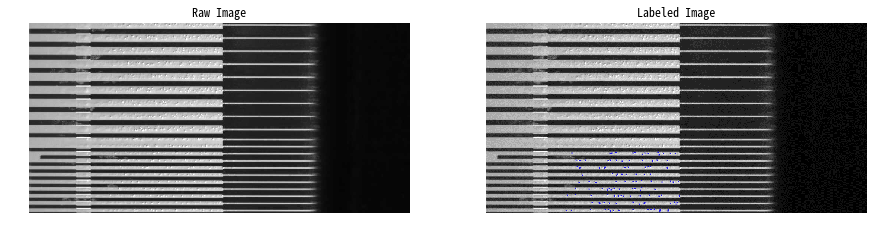

In [2]:
data=load_cofroi()

img_s = data.cofimg
img_mc = data.labeledimg
cfg = data.cfg
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img_s)
plt.axis('off')
plt.title('Raw Image')
plt.subplot(122)
plt.imshow(img_mc)
plt.axis('off')
plt.title('Labeled Image')

### 一. 擷取Pin
**Step 1** 確認每一根Pin的高度位置與它所在的圖檔路徑   
- 作法與規則: 
    - 在水平方向取平均灰度值
    - pin的顏色較淺, 所以灰度值較高, 透過門檻值找到pin的y軸位置
    - 找出連續的y軸位置, 連續的一段y軸表示一根pin
    - 篩選出合格的pin (pin高度在預定義的規格內)

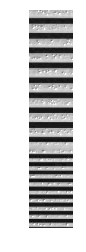

[{'height': 10, 'pid_id': 0, 'row_end': 357, 'row_start': 348},
 {'height': 10, 'pid_id': 1, 'row_end': 376, 'row_start': 367},
 {'height': 10, 'pid_id': 2, 'row_end': 395, 'row_start': 386},
 {'height': 10, 'pid_id': 3, 'row_end': 414, 'row_start': 405},
 {'height': 9, 'pid_id': 4, 'row_end': 432, 'row_start': 424},
 {'height': 9, 'pid_id': 5, 'row_end': 451, 'row_start': 443},
 {'height': 9, 'pid_id': 6, 'row_end': 470, 'row_start': 462},
 {'height': 9, 'pid_id': 7, 'row_end': 489, 'row_start': 481},
 {'height': 9, 'pid_id': 8, 'row_end': 508, 'row_start': 500}]

In [3]:
#Pin = namedtuple('Pin', 'pid_id, row_start, row_end, height, col_start, col_end, width')
height,width = img_s.shape[:2]
img_1 = img_s[:, int(width*0.3):int(width*0.4), 0] #先切一部分的pin圖像
avg_y = np.average(img_1,axis=1) #水平方向取平均灰度值
row_idxs = np.where(avg_y>=cfg.pix_value_thld1)[0] #平均灰度值有大於pix_value_thld1門檻的X位置 (pin的顏色較淺, 所以灰度值較高, 透過門檻值找到pin的y軸位置)
row_idx_lst = [list(group) for group in mit.consecutive_groups(row_idxs)] #群集出每一根Pin的高度範圍 (找出連續的y軸位置, 連續的一段y軸表示一根pin)
valid_pins = filter(lambda x: (len(x)<=cfg.pin_height_thld_UB) & (len(x)>=cfg.pin_height_thld_LB), row_idx_lst) #找出合格的pin (高度在預定義的規格內)
#pins = list(map(lambda x: [x[0], x[1][0], x[1][-1], len(x[1])] , enumerate(valid_pins))) #把每一根pin的資訊儲存在pins內
#pins = list(map(lambda x: Pin(pid_id=x[0], row_start=x[1][0], row_end=x[1][-1], height=len(x[1]), col_start=None,col_end=None,width=None ) , enumerate(valid_pins))) #把每一根pin的資訊儲存在pins內
pins = list(map(lambda x: Bunch(pid_id=x[0], row_start=x[1][0], row_end=x[1][-1], height=len(x[1])) , enumerate(valid_pins))) #把每一根pin的資訊儲存在pins內

plt.imshow(img_1, cmap='gray')
plt.axis('off')
plt.show()
display(pins)


**Step2 確認每一根Pin的長度位置**  
- 作法與規則: 
    - 只取第二根Pin的圖像為基準,來決定出所有Pin的長度的結束位置
    - 垂直方向取最小灰度值, 因為pin比較亮, 當灰度值低於門檻時, 表示為pin的結束位置
    - 根據預定一個pin長度回推pin的開始位置

In [20]:
pin_golden = pins[1] #只取第二根Pin的圖像為基準,來決定出所有Pin的長度的結束位置
img_1 = img_s[pin_golden.row_start:pin_golden.row_end+1, int(width*0.33):int(width*0.55), 0]
min_x = np.min(img_1,axis=0) #垂直方向取最小灰度值, 因為pin比較亮, 當灰度值低於門檻時, 表示為pin的結束位置
pin_column_end = int(width*0.33) + np.where(min_x >= cfg.pix_value_thld2)[0].max() #決定Pin長度的結束位置
pin_column_start = pin_column_end - cfg.zone_visible_lehgth + 1 #決定Pin長度的開始位置


display(Image.fromarray(img_1))
print(f'pin起始位置:{pin_column_start}, 結束位置:{pin_column_end}')
display(Image.fromarray(img_s[pin_golden.row_start:pin_golden.row_end+1, pin_column_start:pin_column_end, 0]))


pin起始位置:160, 結束位置:519


**Step 3: 修正pin起始位置**  
- 作法與規則: 找到PIN前方白白亮亮的地方當作修正後的起始位置(依樣式設定一個灰度值的門檻)

Text(0.5,1,'修正位移:6, pin起始位置166')

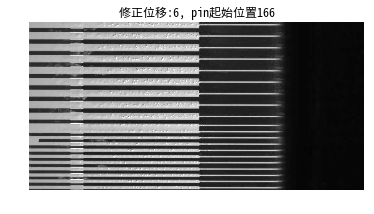

In [21]:
def getfixpoint(pin):
    tmp = list(map(lambda x: (img_s[pin.row_start-3,pin_column_start+x,0] <= cfg.pix_value_thld3), range(30)))
    fixpoint = np.where(tmp)[0][0]
    return fixpoint

update_lengths = list(map(lambda pin: getfixpoint(pin), pins))
update_length = max(update_lengths,key=update_lengths.count)
pin_column_start = pin_column_start + update_length


for pin in pins:
    pin.col_start, pin.col_end, pin.width = pin_column_start, pin_column_end, pin_column_end-pin_column_start+1


plt.figure(figsize=(6,6))
plt.imshow(img_s)
plt.axis('off')
plt.title(f'修正位移:{update_length}, pin起始位置{pin_column_start}')


### 二. 擷取候選粒子(X)與標注粒子(Y):
**Step 4 偵測在Pin上的顯微鏡已標註粒子位置**
    - 作法與規則: 
        - 搜尋藍點
        - 找出藍點的輪廓
        - 找到輪廓的重心
        - 篩選面積>0的輪廓

In [22]:
pin = pins[0]
pin.row_start
pin_img_mc = img_mc[pin.row_start:pin.row_end+1,pin.col_start:pin.col_end+1]               
pin_img_m_red = cv2.inRange(pin_img_mc, cfg.lower_red, cfg.upper_red) # 在Pin的ROI有效區域內,搜尋出藍點在哪裡
display(Image.fromarray(pin_img_mc))
display(Image.fromarray(pin_img_m_red))

def getcenterx(contour):
    '''
    透過moments計算輪廓的空間矩, 其中輪廓的重心為m10/m00
    '''
    M = cv2.moments(contour)
    return(M["m00"], int(M["m10"] / M["m00"])) 
    
_, contours, __ = cv2.findContours(pin_img_m_red,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #找出每個標示紅點的輪廓    
microscope_particles = list(map(lambda c: getcenterx(c), contours)) #找到輪廓重心的x座標
microscope_particles = list(filter(lambda x: x[0]>0, microscope_particles)) #篩選面積>0的輪廓
microscope_particles = list(map(lambda x:x[1],microscope_particles))
microscope_particles = sorted(set(microscope_particles))    
microscope_particles_count = len(microscope_particles)
print(f'標註點的X軸位置: {microscope_particles}')

標註點的X軸位置: [64, 166, 171, 182, 228, 233, 254, 260, 269, 295, 298, 310, 329, 343]


**Step 5 算法偵測在Pin上的具有候選資格的粒子位置**
- 前處理: 每根pin分六段調整灰度值, 讓每一段的平均灰度值都為128
- 規則: 先取出X軸灰度值最大的前30個位置, 再分別針對這30個X軸位置, 取出Y軸灰度值最大的位置

In [7]:

pin_img = img_s[pin.row_start:pin.row_end+1,pin.col_start:pin.col_end+1,0].copy() #取出每根Pin的ROI有效區域所構成的圖像
pin_img_height, pin_img_width = pin_img.shape
print('pin的原始圖像:')
display(Image.fromarray(pin_img))
#將Pin圖像切分成6段,調整每段的灰度值-->平均值調整為128
pi=0
for i in np.linspace(0,pin_img_width,7):
    if i==0:
        continue
    i=int(i)
    pin_img_adjust = int(np.mean(pin_img[:,pi:i]))-128
    pin_img[:,pi:i] = (pin_img[:,pi:i]-pin_img_adjust).clip(0, 255)                      
    pi=i
print('pin的增強後圖像:')    
display(Image.fromarray(pin_img))    

f_max = np.max(pin_img,axis=0) #在垂直方向取灰度最大值
candidate_particles = sorted(f_max.argsort()[-cfg.candidate_particle_count:])#挑出X軸灰度值最大的前30個粒子為候選資格粒子
candidate_particles = list(filter(lambda cp: (2 <= cp)&( cp <= pin_img_width-2), candidate_particles))
candidate_particles_y = list(map(lambda cp: np.argmax(pin_img[:,cp]), candidate_particles)) # 候選資格的粒子的y軸位置

print('候選粒子: ')
pin_img_cp = pin_img.copy()
for x,y in list(zip(candidate_particles, candidate_particles_y)):
    pin_img_cp[y-1:y+1,x-1:x+1]=255
display(Image.fromarray(pin_img_cp))        

pin的原始圖像:


pin的增強後圖像:


候選粒子: 


**Step 6 比對候選粒子與標注粒子**  
- 具有候選資格的粒子,將被歸類為兩類:(1)是粒子;(2)不是粒子  
- 規則: 當候選粒子的鄰近4個pixel內有出現人工標識的粒子,則它為(1)是粒子, 反之則它為(2)不是粒子
- 將候選粒子擴展為候選粒子小圖: 以候選粒子的(x位置,y位置)為中心,擴展2個pixel,構成候選粒子小圖(size=5x5)

In [8]:
print('候選粒子: ')
pin_img_cp = pin_img.copy()
for x,y in list(zip(candidate_particles, candidate_particles_y)):
    pin_img_cp[y-1:y+1,x-1:x+1]=255
display(Image.fromarray(pin_img_cp))        

候選粒子: 


pin的原始圖像:


True Positive 候選粒子: 


False Positive 候選粒子: 


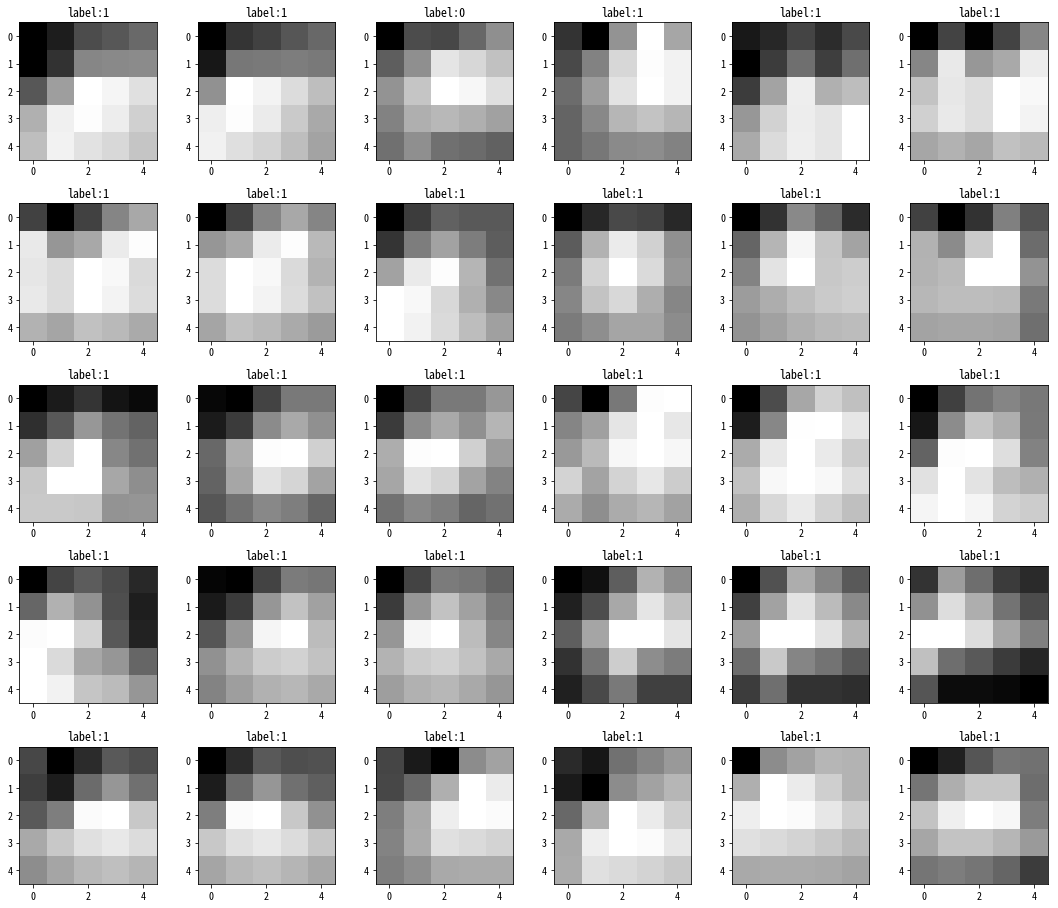

In [25]:
img_label=[]
particle_imgs=[]
if microscope_particles_count > 0:
    tmplist = []
    for cpx, cpy in zip(candidate_particles, candidate_particles_y):
        wl= min(max(0, cpx - cfg.re_height_half), pin_img_width-cfg.re_width)
        wr = min(max(2*cfg.re_width_half, cpx + cfg.re_width_half), pin_img_width-1)
        ht=min(max(0, cpy - cfg.re_height_half), pin_img_height-cfg.re_height)
        hb=min(max(2*cfg.re_height_half, cpy + cfg.re_height_half), pin_img_height-1)
        tmplist.append((wl, wr, ht,hb))
        
        particle_img = pin_img[ht:hb+1,wl:wr+1]
        
        particle_imgs.append(particle_img.flatten()) #將候選粒子5x5小圖拉瓶構成一向量
        isparticles = list(map(lambda x: (x<=cpx+4) & (x>=cpx-4), microscope_particles))
        is_particle = int(np.array(isparticles).any())
        img_label.append(is_particle)


print('pin的原始圖像:')
display(Image.fromarray(img_s[pin.row_start:pin.row_end+1,pin.col_start:pin.col_end+1,0]))
print('True Positive 候選粒子: ')
pin_img_cp = pin_img.copy()
for x,y,label in list(zip(candidate_particles, candidate_particles_y, img_label)):
    if label==1:
        pin_img_cp[y-1:y+1,x-1:x+1]=255
display(Image.fromarray(pin_img_cp))        

print('False Positive 候選粒子: ')
pin_img_cp = pin_img.copy()
for x,y,label in list(zip(candidate_particles, candidate_particles_y, img_label)):
    if label==0:
        pin_img_cp[y-1:y+1,x-1:x+1]=255
display(Image.fromarray(pin_img_cp))        

plt.figure(figsize=(15,15))
for i, cpimg in enumerate(particle_imgs):
    plt.subplot(6,6,1+i)
    plt.imshow(cpimg.reshape((5,5)), cmap='gray')
    plt.title(f'label:{img_label[i]}')
plt.tight_layout()
plt.show()    
            